In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from functools import partial
import sys
sys.path.insert(0, '..')
import harmonic as hm
sys.path.append("../examples")
import utils

~~Starting in linear space to get a feel for it, then will go onto log space!~~
Nevermind that, go straight into log space

In [9]:
def ln_likelihood(x):
    ln_f = np.log((x[0]**2+x[1]-11.0)**2+(x[0]+x[1]**2-7.0)**2) # this caused overflow
    return ln_f

In [3]:
def ln_prior_uniform(x, xmin=-6.0, xmax=6.0, ymin=-6.0, ymax=6.0):
    """Compute log_e of uniform prior.
    
    Args: 
    
        x: Position at which to evaluate prior.
        
        xmin: Uniform prior minimum x edge (first dimension).
        
        xmax: Uniform prior maximum x edge (first dimension).
        
        ymin: Uniform prior minimum y edge (second dimension).
        
        ymax: Uniform prior maximum y edge (second dimension).
        
    Returns:
    
        double: Value of prior at specified point.
        
    """
        
    if x[0] >= xmin and x[0] <= xmax and x[1] >= ymin and x[1] <= ymax:        
        return 1.0 / ( (xmax - xmin) * (ymax - ymin) )
    else:
        return 0.0

In [4]:
def ln_posterior(x, ln_prior):
    """Compute log_e of posterior.
    
    Args: 
    
        x: Position at which to evaluate posterior.
        
        a: First parameter of Rosenbrock function.
        
        b: First parameter of Rosenbrock function.
        
        ln_prior: Prior function.
        
    Returns:
    
        double: Posterior at specified point.
        
    """
    
    ln_L = ln_likelihood(x)

    if not np.isfinite(ln_L):
        return -np.inf
    else:
        return ln_prior(x) + ln_L

In [5]:
# Define parameters for emcee sampling
ndim = 2                    # number of dimensions
nchains = 200               # total number of chains to compute
samples_per_chain = 5000    # number of samples per chain
nburn = 2000                # number of samples to discard as burn in

# Initialize random seed
np.random.seed(2)

# Define ln_prior function
xmin = -6.0
xmax = 6.0
ymin = -6.0
ymax = 6.0  
ln_prior = partial(ln_prior_uniform, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)  

In [8]:
# Set initial random position and state
pos = np.random.rand(ndim * nchains).reshape((nchains, ndim)) * 0.1   
rstate = np.random.get_state()

# Instantiate and execute sampler 
sampler = emcee.EnsembleSampler(nchains, ndim, ln_posterior, args=[ln_prior])
(pos, prob, state) = sampler.run_mcmc(pos, samples_per_chain, rstate0=rstate) 

# Collect samples into contiguous numpy arrays (discarding burn in)
samples = np.ascontiguousarray(sampler.chain[:,nburn:,:])
lnprob = np.ascontiguousarray(sampler.lnprobability[:,nburn:])

/opt/miniconda3/envs/harmonic/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


In [11]:
ln_posterior_func = partial(ln_posterior, ln_prior=ln_prior)
ln_posterior_grid, x_grid, y_grid = utils.eval_func_on_grid(
                                        ln_posterior_func, 
                                        xmin=xmin, xmax=xmax, 
                                        ymin=ymin, ymax=ymax, 
                                        nx=1000, ny=1000)
dx = x_grid[0,1] - x_grid[0,0]
dy = y_grid[1,0] - y_grid[0,0]

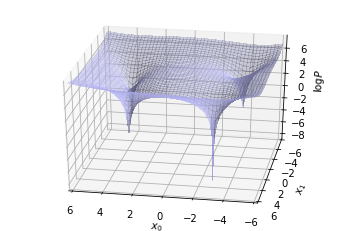

In [12]:
ax = utils.plot_surface(ln_posterior_grid, x_grid, y_grid, 
                        samples[0,:,:].reshape((-1, ndim)), 
                        lnprob[0,:].reshape((-1, 1)))              
ax.set_zlabel(r'$\log P$')
ax.view_init(30,100)
plt.show(block=False)  